## Quantum Circuit Functions

<h4> Imports </h4>

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

<h3> Defining a quantum circuit function (AKA quantum_function): </h3>
A quantum circuit is constructed as a special Python function, a quantum circuit function, or quantum function in short. 

PennyLane uses the term <b>wires</b> to refer to a quantum subsystem—for most devices, this corresponds to a <b>qubit</b>. For <i>continuous-variable devices, a wire corresponds to a <b>quantum mode</b>. </i>

In [2]:
def my_quantum_function(x, y):
    qml.RZ(x, wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(y, wires=1)
    return qml.expval(qml.PauliZ(1))

In [3]:
print(my_quantum_function(1,0))

expval(PauliZ(wires=[1]))


<h3>Quantum functions are a restricted subset of Python functions, adhering to the following constraints:</h3>
<ul>
    <li>The <b>quantum function accepts classical inputs</b>, and consists of quantum operations or sequences of operations called <b>Templates</b>, using one instruction per line.</li>
    <li>The function can contain classical flow control structures such as for loops, but in general they must not depend on the parameters of the function.</li>
    <li>The quantum function must always return either a single or a tuple of measured observable values, by applying a measurement function to a <b>qubit observable</b> or continuous-value observable.</li>
</ul>

## Defining a device

To run—and later optimize—a quantum circuit, one needs to first specify a <b>computational device</b>.

The <b>device</b> is an <b>instance</b> of the <b>Device class</b>, and can represent either a <b>simulator</b> or <b>hardware device</b>. 

They can be instantiated using the device loader. PennyLane offers some basic devices such as the <b>'default.qubit'</b> and <b>'default.gaussian'</b> simulators.  

When loading a device, the name of the device must always be specified. Further options can then be passed as <b>keyword arguments</b>; these options can differ based on the device. For the in-built 'default.qubit' and 'default.gaussian' devices, the options are:
<ul>
    <li><b>wires (int or Iterable)</b>: Number of subsystems represented by the device, or iterable that contains unique labels for the subsystems as numbers (i.e., [-1, 0, 2]) and/or strings (['ancilla', 'q1', 'q2']).</li>
    <li><b>analytic (bool)</b>: Indicates if the device should calculate expectations and variances analytically. Only possible with simulator devices. <b>Default = True</b>. </li>
    <li><b>shots (int)</b>: How many times the circuit should be evaluated (or sampled) to estimate the expectation values. <b>Default = 1000</b>.</li>
</ul>

In [42]:
#dev = qml.device('default.qubit', wires=2, shots=1000, analytic=False)
dev = qml.device('default.qubit', wires=['wire1', 'wire2'], shots=1000, analytic=False)

In [54]:
def my_quantum_function(x, y):
    qml.RZ(x, wires='wire1')
    qml.CNOT(wires=['wire1','wire2'])
    qml.RY(y, wires='wire2')
    return qml.expval(qml.PauliX('wire2'))

## Creating a Quantum Node

Together, a quantum function and a device are used to create a quantum node or QNode object, which <b>wraps the quantum function and binds it to the device</b>.

<b>Note:</b> The QNode can be <b>used to compute the result of a quantum circuit</b> as if it was a standard Python function. It takes the <b>same arguments as the original quantum function</b>.

In [55]:
circuit = qml.QNode(my_quantum_function, dev)

In [56]:
lst = [print(circuit(0, 1)) for i in range(10)]

WireError: Did not find some of the wires ('wire1',) on device with wires (0, 1).

In [50]:
print(circuit.draw())

 0: ──RZ(0.543)──╭C─────────────┤     
 1: ─────────────╰X──RY(0.543)──┤ ⟨Z⟩ 



### QNode Decorator (recommended) << need to debug

In [17]:
dev1 = qml.device('default.qubit', wires=2)

qml.qnode(dev1)
def new_circuit(x):
    qml.RZ(x, wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(x, wires=1)
    return qml.expval(qml.PauliX(1))

In [18]:
lst = [print(new_circuit(0.543)) for i in range(10)]

expval(PauliX(wires=[1]))
expval(PauliX(wires=[1]))
expval(PauliX(wires=[1]))
expval(PauliX(wires=[1]))
expval(PauliX(wires=[1]))
expval(PauliX(wires=[1]))
expval(PauliX(wires=[1]))
expval(PauliX(wires=[1]))
expval(PauliX(wires=[1]))
expval(PauliX(wires=[1]))


In [20]:
dev2 = qml.device('default.qubit', wires=2)
dev3 = qml.device('default.qubit', wires=2)

@qml.qnode(dev2)
def x_rotations(params):
    qml.RX(params[0], wires=0)
    qml.RX(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev3)
def y_rotations(params):
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.Hadamard(0))

In [21]:
qnodes = qml.QNodeCollection([x_rotations, y_rotations])
len(qnodes)

2

In [22]:
qnodes([0.2, 0.1])

array([0.98006658, 0.70703636])

In [43]:
dev4 = qml.device("default.qubit", wires=1)

@qml.qnode(dev4)
def simpleCircuit(x):
    qml.PauliX(x)
    return qml.expval(qml.PauliX(0))
print(simpleCircuit(0))

0.0


In [44]:
qml.draw(simpleCircuit)

<function __main__.simpleCircuit(x)>

<b>---------------------------------------------------------------------------------------------</b>

## QCNN dump

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/Desktop/quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [16]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliX(j)) for j in range(4)]

In [23]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [24]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


FileNotFoundError: [Errno 2] No such file or directory: '/Desktop/quanvolution/q_train_images.npy'

In [12]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [18]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=1,
)

Epoch 1/30
13/13 [==============================] - 0s 11ms/step - loss: 2.9409 - accuracy: 0.1800 - val_loss: 2.1294 - val_accuracy: 0.3000
Epoch 2/30
13/13 [==============================] - 0s 2ms/step - loss: 2.1545 - accuracy: 0.1600 - val_loss: 2.0186 - val_accuracy: 0.3667
Epoch 3/30
13/13 [==============================] - 0s 2ms/step - loss: 1.7096 - accuracy: 0.4600 - val_loss: 1.8770 - val_accuracy: 0.4333
Epoch 4/30
13/13 [==============================] - 0s 2ms/step - loss: 1.3116 - accuracy: 0.6200 - val_loss: 1.6574 - val_accuracy: 0.4667
Epoch 5/30
13/13 [==============================] - 0s 2ms/step - loss: 1.1274 - accuracy: 0.7400 - val_loss: 1.5339 - val_accuracy: 0.4667
Epoch 6/30
13/13 [==============================] - 0s 2ms/step - loss: 0.9405 - accuracy: 0.8000 - val_loss: 1.5479 - val_accuracy: 0.4667
Epoch 7/30
13/13 [==============================] - 0s 2ms/step - loss: 0.7210 - accuracy: 0.8800 - val_loss: 1.3909 - val_accuracy: 0.5333
Epoch 8/30
13/13 [=

In [19]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.3345 - accuracy: 0.1400 - val_loss: 2.1068 - val_accuracy: 0.2333
Epoch 2/30
13/13 - 0s - loss: 1.9518 - accuracy: 0.4800 - val_loss: 1.9583 - val_accuracy: 0.3667
Epoch 3/30
13/13 - 0s - loss: 1.6601 - accuracy: 0.6600 - val_loss: 1.8287 - val_accuracy: 0.5000
Epoch 4/30
13/13 - 0s - loss: 1.4266 - accuracy: 0.7400 - val_loss: 1.7022 - val_accuracy: 0.5333
Epoch 5/30
13/13 - 0s - loss: 1.2269 - accuracy: 0.8600 - val_loss: 1.5919 - val_accuracy: 0.6667
Epoch 6/30
13/13 - 0s - loss: 1.0656 - accuracy: 0.8800 - val_loss: 1.5133 - val_accuracy: 0.6667
Epoch 7/30
13/13 - 0s - loss: 0.9292 - accuracy: 0.9200 - val_loss: 1.4530 - val_accuracy: 0.7333
Epoch 8/30
13/13 - 0s - loss: 0.8154 - accuracy: 0.9400 - val_loss: 1.3936 - val_accuracy: 0.7333
Epoch 9/30
13/13 - 0s - loss: 0.7206 - accuracy: 0.9800 - val_loss: 1.3449 - val_accuracy: 0.7000
Epoch 10/30
13/13 - 0s - loss: 0.6398 - accuracy: 1.0000 - val_loss: 1.3113 - val_accuracy: 0.7000
Epoch 11/30
13/13 -

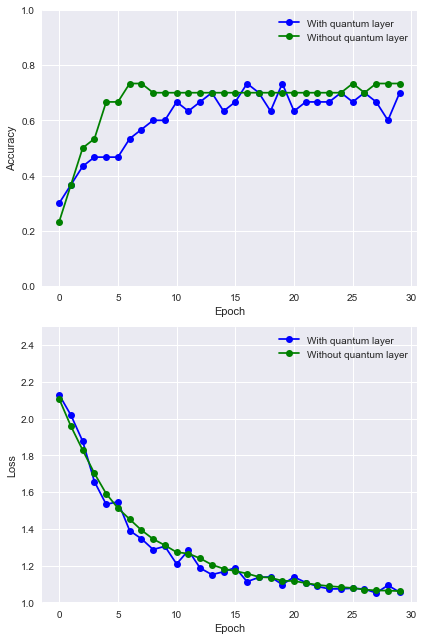

In [20]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

https://arxiv.org/abs/1904.04767